In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import math
import numpy as np
import pandas as pd
import re

from ast import literal_eval
from itertools import product
from matplotlib.transforms import ScaledTranslation
from matplotlib.ticker import NullFormatter
from os import makedirs
from os.path import isdir, isfile
from pathlib import Path
from string import ascii_lowercase
from time import time
from tqdm import tqdm
from constants import *
from UTILS.mutils import njoin, str2bool, str2ls, create_model_dir, convert_train_history
from UTILS.mutils import collect_model_dirs, find_subdirs, load_model_files
from UTILS.figure_utils import matrixify_axs, label_axs
from plot_results import *

# Hyperparam effects

In [30]:
def hyperparam_effects(models_root, fns_manifold='rd', is_rescale_dist=True,
                       qk_shares=[False, True], selected_alphas='1.2,2',
                       metric='val_acc', selected_dataset='imdb',
                       is_op=True):

    # PROCESSING
    global metric_matrix, counter_matrix, nan_counter_matrix, average_metric_matrix, run_perf_all
    global other_model_type, fns_type, layers

    linestyles = ['-', '--', '-.', ':']
    markers = ['o', '8', 'p', 's', 'v']

    assert fns_manifold in ['sphere', 'rd', 'v2_rd'], f'{fns_manifold} does not exist!'
    assert metric in ['train_acc', 'train_loss', 'val_acc', 'val_loss']    
    fns_type = fns_manifold + 'fns' + MODEL_SUFFIX 
    other_model_type = 'dpformer'
    if is_op:
        fns_type = 'op' + fns_type
        other_model_type = 'op' + other_model_type
    model_types_to_plot = [fns_type, other_model_type]

    is_op, is_rescale_dist = str2bool(is_op), str2bool(is_rescale_dist)
    qk_shares = str2ls(qk_shares)        
    selected_alphas = [float(selected_alpha) for selected_alpha in str2ls(selected_alphas)]
    eps = 1

    # Regular expression pattern
    pattern = r"\d+L-hidden=\d+-max_len=512"
    if is_rescale_dist:            
        pattern += "-rescaled"

    # Extract matching subfolders
    layer_dirs_dict = {}
    layers, emb_ds = [], []
    for layer_dir in os.listdir(models_root):
        is_match = re.fullmatch(pattern, layer_dir)
        if is_match:
            #layer, emb_d = int(is_match.group(1)), int(is_match.group(2))
            layer = int(layer_dir.split('L')[0])          
            #emb_d = int(layer_dir.split('-')[1].split('=')[1])
            emb_d = int(layer_dir.split('-')[1].split('=')[1])  
            if isdir(njoin(models_root, layer_dir)):
                layer_dirs_dict[f'{layer}-{emb_d}'] = njoin(models_root, layer_dir)
            layers.append(layer)
            emb_ds.append(emb_d)
    layers = np.array(sorted(list(set(layers)))); layers = layers[layers < 4]
    emb_ds = np.array(sorted(list(set(emb_ds)))); emb_ds = emb_ds[emb_ds < 65]
    
    #nrows, ncols = len(qk_shares), len(selected_alphas)
    nrows, ncols = len(qk_shares), len(layers)

    # (model_types, qk_share, L, d_model)
    N_model_types = len(selected_alphas) + 1
    average_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    std_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    max_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    min_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    average_metric_matrix[:] = np.nan
    std_metric_matrix[:] = np.nan
    max_metric_matrix[:] = np.nan
    min_metric_matrix[:] = np.nan
    counter_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    nan_counter_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    model_types_plotted = []
    for (qk_ii,qk_share),(layer_idx,layer),(emb_d_idx,emb_d) in\
         product(enumerate(qk_shares),enumerate(layers),enumerate(emb_ds)):

        qk_share_dirname = 'config_qqv' if qk_share else 'config_qkv'
        print(f'qk_share = {qk_share}, layer = {layer}, emb_d = {emb_d}')    
        # directories matching the above setting in the triple for loop
        if f'{layer}-{emb_d}' in layer_dirs_dict.keys():
            if qk_share_dirname in os.listdir(layer_dirs_dict[f'{layer}-{emb_d}']):
                setting_dir = njoin(layer_dirs_dict[f'{layer}-{emb_d}'], qk_share_dirname)
            else:
                continue
        else:
            continue
        # for _ in range(2):
        #     setting_dir = njoin(setting_dir, os.listdir(setting_dir)[0])
        setting_dir = njoin(setting_dir, 'imdb')
        setting_dir = njoin(setting_dir, os.listdir(setting_dir)[0])
        DCT_ALL = collect_model_dirs(setting_dir, suffix=MODEL_SUFFIX)
        model_df = DCT_ALL[fns_type].dropna(subset='alpha')
        model_df.reset_index(drop=True, inplace=True)

        for model_type in model_types_to_plot:
            if model_type in DCT_ALL.keys():
                df_model = DCT_ALL[model_type]
            else:
                continue
            matching_df = df_model[(df_model['ensembles']>0)&(df_model['qk_share']==qk_share)&
                                   (df_model['is_op']==is_op)&                                    
                                   (df_model['model_dir'].str.contains(selected_dataset))&
                                   (df_model['model_dir'].str.contains(f'/{model_type}-'))]

            if model_type not in model_types_plotted:
                model_types_plotted.append(model_type)
            lstyle_model = LINESTYLE_DICT[model_type]            
            for alpha_idx, alpha in enumerate(selected_alphas):  
                # if is fns type
                is_fns = 'fns' in model_type
                alpha = alpha if is_fns else None
                # -------------------- SINK, DP -------------------- 
                model_info = matching_df 
                # -------------------- FNS --------------------
                if is_fns:
                    condition = (matching_df['alpha']==alpha) & (matching_df['bandwidth']==eps)
                    model_info = model_info[condition]
                else:
                    alpha_idx = len(selected_alphas)
                
                if model_info.shape[0] > 0:
                    seeds, qk_share = (model_info[k].item() for k in ('seeds', 'qk_share'))                
                    epochs, run_perf_all = load_seed_runs(model_info['model_dir'].item(), seeds, metric)   
                else:
                    continue

                if run_perf_all is not None:
                    metric_curves = get_metric_curves(run_perf_all)  

                if run_perf_all is not None:
                    average_metric_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                        np.nanmean(run_perf_all.loc[run_perf_all.index[-1]:,metric])
                        #np.nanmedian(run_perf_all.loc[run_perf_all.index[-1]:,metric])                                                
                    std_metric_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                        np.nanstd(run_perf_all.loc[run_perf_all.index[-1]:,metric])
                    max_metric_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                        np.nanmax(run_perf_all.loc[run_perf_all.index[-1]:,metric])
                    min_metric_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                        np.nanmin(run_perf_all.loc[run_perf_all.index[-1]:,metric])
                    counter_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                        (~np.isnan(run_perf_all.loc[run_perf_all.index[-1]:,metric].to_numpy())).sum()                        
                    nan_counter_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                        (np.isnan(run_perf_all.loc[run_perf_all.index[-1]:,metric].to_numpy())).sum()

                if not is_fns:
                    break  # only do once if model is NOT FNS type                            

    # # PLOTTING
    # fig, axs = plt.subplots(nrows,ncols,figsize=(6, 4))  # layout='constrained'    
    # axs = matrixify_axs(axs, nrows, ncols)  # convert axs to 2D array       
    # # label_axs(fig, axs)  # alphabetically label subfigures     
    # for row in range(nrows):
    #     for col in range(ncols):
    #         ax = axs[row,col]
    #         for aidx in range(len(selected_alphas) + 1):
    #             average_metrics = average_metric_matrix[row,aidx,col]
    #             std_metrics = std_metric_matrix[row,aidx,col]
    #             max_metrics = max_metric_matrix[row,aidx,col]
    #             min_metrics = min_metric_matrix[row,aidx,col]
    #             mask = ~np.isnan(average_metrics)  # mask nan-valued entries

    #             is_fns = aidx < len(selected_alphas)
    #             # color                                 
    #             if is_fns:
    #                 alpha = selected_alphas[aidx]
    #                 legend_label = rf'$\alpha={selected_alphas[aidx]}$'
    #                 color = HYP_CMAP(HYP_CNORM(alpha))  
    #                 model_type = fns_type                  
    #             else:
    #                 legend_label = 'Transformer'
    #                 model_type = other_model_type
    #                 color = OTHER_COLORS_DICT[model_type]
    #             linestyle = LINESTYLE_DICT[model_type]
            
    #             X = np.array([1,2,3,4])
                
    #             # No error bars
    #             # ax.plot(emb_ds[mask], average_metrics[mask], 
    #             #         c=color, linestyle=linestyle, label=legend_label)
                
    #             # Error bars = standard deviation
    #             ax.errorbar(X, average_metrics[mask], yerr=std_metrics[mask], fmt='.', c=color, linestyle='-', label=legend_label)
                
    #             # # Error bars = full range
    #             # errs = np.zeros((2, len(X)))
    #             # errs[0,:] = max_metrics[mask] - average_metrics[mask]
    #             # errs[1,:] = average_metrics[mask] - min_metrics[mask]
    #             # ax.errorbar(X, average_metrics[mask], yerr=errs, fmt='.', c=color, linestyle='-', label=legend_label)

    #             # if (row,col,aidx) == (0,0,0):
    #             #     axs[0,0].plot([],[],
    #             #                   linestyle=LINESTYLE_DICT[model_type],c='k',
    #             #                   label=NAMES_DICT[model_type])

    #             ax.set_xticks(X)
    #             ax.set_xticklabels(list(emb_ds))    
    #             ax.xaxis.set_minor_formatter(NullFormatter())   
    #             ax.spines['top'].set_visible(False)
    #             ax.spines['right'].set_visible(False)

    # axs[0,0].set_ylim([72,86])
    # axs[0,0].set_yticks([75, 80, 85])

    # axs[0,1].legend(frameon=False)
    # #axs[0,0].set_ylim([70,85.5])

    # for col in range(ncols):
    #     #axs[0,col].set_title(rf'{NAMES_DICT[fns_type]} ($\alpha = {selected_alphas[col]}$)')
    #     axs[0,col].set_title(rf'$L = {layers[col]}$')
    # # if other_model_type in DCT_ALL.keys():        
    # #     axs[0,ncols].set_title(f'{NAMES_DICT[other_model_type]}')
    # for row in range(nrows):
    #     qk_share = qk_shares[row]
    #     if qk_share:
    #         axs[row,0].text(0, 75, r'$Q = K$', ha='center', va='center', rotation=90)
    #         axs[row,0].set_ylabel(r'$Testing accuracy (\%)$')
    #     else:
    #         axs[row,0].text(0, 75, r'$Q \neq K$', ha='center', va='center', rotation=90)
    #         axs[row,0].set_ylabel(r'$Testing accuracy (\%)$')
              
    # # x/y axis label
    # #fig.supxlabel('Embedding Dimension'); fig.supylabel('Layers')
    # for col in range(axs.shape[1]):
    #     axs[-1,col].set_xlabel(r'Dimension $d$')
    
    # PLOTTING (Just the two I think are most relevant)
    fig, axs = plt.subplots(1,2,figsize=(5, 2))
    
    ax = axs[0]
    ax.set_title(r'$Q \neq K$')
    for aidx in range(len(selected_alphas) + 1):
        for l in [1,2]:
            average_metrics = average_metric_matrix[0,aidx,l-1]
            std_metrics = std_metric_matrix[0,aidx,l-1]
            is_fns = aidx < len(selected_alphas)
            # color                                 
            if is_fns:
                alpha = selected_alphas[aidx]
                legend_label = rf'$\alpha={selected_alphas[aidx]}$'
                if (alpha == 1.2):
                    color = '#2E63A6' if l == 2 else '#5391BF'
                elif (alpha == 2.0):
                    color = '#A4292F' if l == 2 else '#C86653'                           
                model_type = fns_type       
            else: 
                legend_label = 'DP'
                model_type = other_model_type
                color = 'k' if l == 2 else '#636363'
                # color = 'k'
            linestyle = (0, (2,1)) if l == 2 else '-'
            X = np.array([1,2,3,4])
            ax.errorbar(X, average_metrics, yerr=std_metrics, fmt='.', linestyle=linestyle, label=legend_label + r' $(L=1)$', c=color, clip_on=False)

    ax = axs[1]
    ax.set_title(r'$Q = K$')
    average_metrics = average_metric_matrix[1,0,0]
    std_metrics = std_metric_matrix[1,0,0]
    for aidx in range(len(selected_alphas) + 1):
        for l in [1,2]:
            average_metrics = average_metric_matrix[1,aidx,l-1]
            std_metrics = std_metric_matrix[1,aidx,l-1]
            is_fns = aidx < len(selected_alphas)
            # color      
            if is_fns:
                alpha = selected_alphas[aidx]
                legend_label = rf'$\alpha={selected_alphas[aidx]}$'
                if (alpha == 1.2):
                    color = '#2E63A6' if l == 2 else '#5391BF'
                elif (alpha == 2.0):
                    color = '#A4292F' if l == 2 else '#C86653'                           
                model_type = fns_type       
            else: 
                legend_label = 'DP'
                model_type = other_model_type
                color = 'k' if l == 2 else '#636363'
            linestyle = (0, (2,1)) if l == 2 else '-'
            X = np.array([1,2,3,4])
            ax.errorbar(X, average_metrics, yerr=std_metrics, fmt='.', linestyle=linestyle, label=legend_label + r' $(L={})$'.format(l), c=color, clip_on=False)

    for i, ax in enumerate(axs):
        ax.set_xticks(X)
        ax.set_xticklabels([8, 16, 32, 64])
        ax.set_xlabel(r'Dimension $d$')
        ax.set_ylim(top=85)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axs[0].set_yticks([75,80,85])
    axs[0].set_ylabel('Testing accuracy (%)')

    axs[1].legend(frameon=False, bbox_to_anchor=(1, 1))

    return fig, axs

qk_share = False, layer = 1, emb_d = 8
qk_share = False, layer = 1, emb_d = 16
qk_share = False, layer = 1, emb_d = 32
qk_share = False, layer = 1, emb_d = 64


/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The beha

qk_share = False, layer = 2, emb_d = 8
qk_share = False, layer = 2, emb_d = 16
qk_share = False, layer = 2, emb_d = 32
qk_share = False, layer = 2, emb_d = 64
qk_share = False, layer = 3, emb_d = 8
qk_share = False, layer = 3, emb_d = 16


/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The beha

qk_share = False, layer = 3, emb_d = 32
qk_share = False, layer = 3, emb_d = 64
qk_share = True, layer = 1, emb_d = 8
qk_share = True, layer = 1, emb_d = 16
qk_share = True, layer = 1, emb_d = 32


/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The beha

qk_share = True, layer = 1, emb_d = 64
qk_share = True, layer = 2, emb_d = 8
qk_share = True, layer = 2, emb_d = 16
qk_share = True, layer = 2, emb_d = 32
qk_share = True, layer = 2, emb_d = 64


/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The beha

qk_share = True, layer = 3, emb_d = 8
qk_share = True, layer = 3, emb_d = 16
qk_share = True, layer = 3, emb_d = 32
qk_share = True, layer = 3, emb_d = 64


/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)


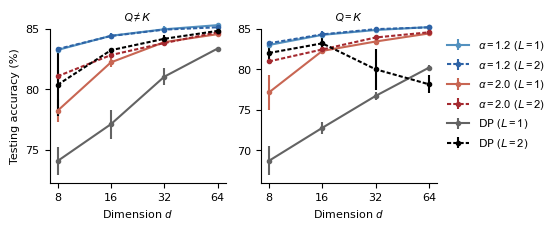

In [31]:
from constants import FIGS_DIR
fig, axs = hyperparam_effects('.droot/L-d-grid/')
SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
fig_file = 'hyperparam_effects'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()

What's the relevance of having L=2 and L=3?
It seems we can simply state that results are similar across for L = 2, 3 for fracformer (which seems to be the case), whilst Transformer requires extra layers (parameters) to catch up. Thus, fractional attention is more expressive. We demonstrate the expressiveness further with other experiments...

# Dynamic inference

In [22]:
def dynamic_inference(models_root, n_layer=1,
                      fns_type='fns', manifold='rd', is_rescale_dist=True, selected_alphas=[1.2, 2.0],
                      is_op=True, qk_shares=[False,True], metric='test_acc',
                      batch_size=64, is_dist_based=False):

    global model_dirs, emb_ds

    # general setting
    batch_size = int(batch_size)
    is_dist_based = str2bool(is_dist_based)    
    fname = 'dist' if is_dist_based else 'prob'
    fname += f'-bs={batch_size}-inference.csv'

    # get layers, emb_ds from regular expression
    pattern = r"\d+L-hidden=\d+-max_len=512"
    if is_rescale_dist:            
        pattern += "-rescaled"

    # Extract matching subfolders
    layer_dirs_dict = {}
    layers, emb_ds = [], []
    for layer_dir in os.listdir(models_root):
        is_match = re.fullmatch(pattern, layer_dir)
        if is_match:
            #layer, emb_d = int(is_match.group(1)), int(is_match.group(2))
            layer = int(layer_dir.split('L')[0])          
            #emb_d = int(layer_dir.split('-')[1].split('=')[1])
            emb_d = int(layer_dir.split('-')[1].split('=')[1])  
            if isdir(njoin(models_root, layer_dir)):
                layer_dirs_dict[f'{n_layer}-{emb_d}'] = njoin(models_root, layer_dir)
            layers.append(layer)
            emb_ds.append(emb_d)
    layers = np.array(sorted(list(set(layers)))); layers = layers[layers < 4]
    emb_ds = np.array(sorted(list(set(emb_ds)))); emb_ds = emb_ds[emb_ds < 65]    
    assert n_layer in layers, f'{n_layer} does not exist!'

    # get all model dirs
    pattern = re.compile(r"model=\d+$")  # seed paths
    all_model_dirs = [str(p) for p in Path(models_root).rglob("*") if p.is_dir() and pattern.search(str(p))]    
    model_dirs = []
    fns_type = manifold + 'fns' + MODEL_SUFFIX
    other_type = 'dp'+MODEL_SUFFIX
    if is_op:
        fns_type = 'op' + fns_type
        other_type = 'op' + other_type
    model_types_to_plot = [fns_type, other_type]
    for model_dir in all_model_dirs:
        is_fns = f'/{fns_type}' in model_dir
        is_dp = f'/{other_type}' in model_dir
        if is_fns:
            for alpha in selected_alphas:
                if f'alpha={float(alpha)}' in model_dir:
                    if model_dir is not None and isfile(njoin(model_dir, fname)):
                        model_dirs.append(model_dir)
        elif is_dp:
            if model_dir is not None and isfile(njoin(model_dir, fname)):
                model_dirs.append(model_dir)

    # number of controlled variables
    inference = pd.read_csv(njoin(model_dirs[0], fname))
    controlled_vars = inference.loc[:,'controlled_variable']  # either distance based or probability based
    N_control_var = len(controlled_vars)
    ensembles = 5  # figure out how to extract this

    metrics_dynamic = np.zeros([len(selected_alphas)+1, len(qk_shares), 
                                len(emb_ds), N_control_var, ensembles])
    metrics_dynamic[:] = np.nan
    for model_dir in model_dirs:
        # load config
        attn_setup, config, run_performance, train_setting = load_model_files(model_dir)
        seed, model_name, qk_share = attn_setup['seed'], attn_setup['model_name'],\
              attn_setup['qk_share']
        hidden = config['hidden']
        is_fns = model_name[-9:] == 'fns' + MODEL_SUFFIX
        if is_fns:
            alpha = attn_setup['alpha']
            alpha_idx = selected_alphas.index(alpha)
        else:
            alpha_idx = len(selected_alphas)
        inference = pd.read_csv(njoin(model_dir, fname))
        metrics_dynamic[alpha_idx, qk_shares.index(qk_share), list(emb_ds).index(hidden), :, seed] =\
              inference.loc[:,metric]

    # PLOTTING
    fig, axs = plt.subplots(1,4,figsize=(6,1.7))
    
    for sidx, didx, alpha_idx in\
          product(range(len(qk_shares)), range(len(emb_ds)), range(len(selected_alphas)+1)):
        if sidx == 0:
            continue
        is_fns = alpha_idx < len(selected_alphas)
        if is_fns:
            alpha = selected_alphas[alpha_idx]
            # color = HYP_CMAP(HYP_CNORM(alpha))
            color = '#2E63A6' if alpha == 1.2 else '#A4292F'
        else:
            # color = OTHER_COLORS_DICT[other_type]
            # color = 'k'
            color = '#636363'

        metric_mean = np.nanmean(metrics_dynamic[alpha_idx,sidx,didx,:,:],-1)
        metric_std = np.nanstd(metrics_dynamic[alpha_idx,sidx,didx,:,:],-1)
              
        if didx == 0:
            axs[didx].plot(controlled_vars, metric_mean,
                                markersize=MARKERSIZE, label=rf'$\alpha$ = {alpha}' if is_fns else 'DP',
                                c=color, linestyle=LINESTYLE_DICT[fns_type])  
        else:
            axs[didx].plot(controlled_vars, metric_mean,
                                markersize=MARKERSIZE, 
                                c=color, linestyle=LINESTYLE_DICT[fns_type])  
        # axs[row, col].errorbar(controlled_vars, metric_mean, yerr=metric_std, fmt='.',
        #                     c=color, linestyle=LINESTYLE_DICT[fns_type])  

        # # error bars
        axs[didx].fill_between(controlled_vars,  metric_mean - metric_std, metric_mean + metric_std,
                                    color=color, alpha=0.2, edgecolor='none')                           

        axs[didx].spines['top'].set_visible(False)
        axs[didx].spines['right'].set_visible(False)
        axs[didx].set_xticks([0,0.5,1])
        axs[didx].set_yticks([0.5,0.7,0.9])
        axs[didx].set_xlim([0,1])
        axs[didx].set_ylim([0.5,0.9])
        axs[didx].set_xlabel(r'$p$')
        axs[didx].set_title(rf'$d = {emb_ds[didx]}$')

    # legends
    # for alpha_idx, alpha in enumerate(selected_alphas):
    #     c_hyp = HYP_CMAP(HYP_CNORM(alpha))   
    #     axs[0,0].plot([], [], c=c_hyp, linestyle=LINESTYLE_DICT[fns_type],
    #                 label=rf'$\alpha$ = {alpha}')    
    # axs[0,0].plot([],[], c=OTHER_COLORS_DICT[other_type],linestyle=LINESTYLE_DICT[other_type])                      
    fig.legend(frameon=False, bbox_to_anchor=(0.75,0.1), ncol=3)
                        
    # control_var_name = 'Distance threshold' if is_dist_based else 'Removal probability'
    # for col in range(2):
    #     axs[0].set_title(rf'$d = {emb_ds[col]}$')
        # axs[0].set_xlabel(control_var_name)
    axs[0].set_ylabel('Testing accuracy (%)')
    # axs[0,0].legend(frameon=False)

    # plt.tight_layout(rect=[0, 0, 0.93, 1])   
    
    return fig, axs        

    # # abbreviate dataset_name
    # dataset = attn_setup['dataset_name']
    # dataset_name_short = ''
    # if isinstance(dataset,str):
    #     if '_' in dataset:
    #         for s in dataset.split('_'):
    #             dataset_name_short += s[0]
    #     else:
    #         dataset_name_short += dataset

    # SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')
    # if not isdir(SAVE_DIR): makedirs(SAVE_DIR)    
    # qkv = 'qqv' if qk_share else 'qkv'
    # fig_file = f'{n_layer}L-{metric}-'
    # if is_dist_based:           
    #     fig_file += f'dynamic_inference_dist.pdf'
    # else:
    #     fig_file += f'dynamic_inference_prob.pdf'
    # plt.savefig(njoin(SAVE_DIR, fig_file))            
    # print(f'Figure saved in {njoin(SAVE_DIR, fig_file)}')    

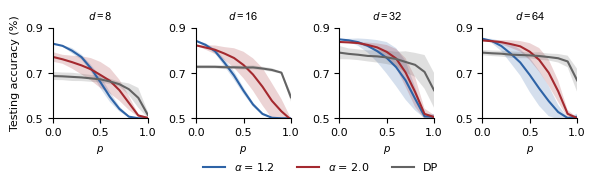

In [23]:
from constants import FIGS_DIR
fig, axs = dynamic_inference('.droot/L-d-grid/')
plt.tight_layout()
SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
fig_file = 'dynamic_inference'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()

Something along the lines of: We have shown that fractional attention exceeds ordinary attention. We now perform an ablation study to demonstrate that this improvement truly derives from the attention mechanism. In particular, we show that the observed performance and fractional attention is inextricable. In contrast, with ordinary attention, relatively more information is stored in the fully-connected layers rather than attention, resulting in an above-chance level accuracy when all tokens are removed. This represents a lesser expressivity of the attention mechanism. 

We define an intuitive index for the amount of information that is lost by randomly removing tokens. Let $p$ be the removal probability. Define $$\Delta_p = \text{acc. at $p$} - \text{chance-level}$$. Then fraction of information lost at $p$ is $1 - \Delta_p / \Delta_0$. 

Also, it seems that for this case it is sufficient to show $Q = K$. You just state in the main text that the results are similar, but slightly less pronounced, for $Q \neq K$. 

# Phase ensembles

In [32]:
def phase_ensembles(models_root, selected_dataset='imdb',
                    fns_manifold='rd', qk_share=True, selected_alphas='1,2',
                    metrics='val_acc,val_loss',
                    is_ops = [True],  # [False,True]
                    cbar_separate=False, display=False):

    global qk_shares

    assert fns_manifold in ['sp', 'rd', 'v2_rd'], f'{fns_manifold} does not exist!'
    qk_share, cbar_separate, display = map(str2bool, (qk_share, cbar_separate, display))
    metrics, is_ops = str2ls(metrics), str2ls(is_ops)

    # collect subdirs containing the model directories
    model_root_dirs = models_roots = find_subdirs(models_root, MODEL_SUFFIX)
    print(model_root_dirs)                  

    # all trained model types
    model_types = []   
    DCT_ALL = {} 
    for model_root_dir in model_root_dirs:
        DCT_cur = collect_model_dirs(model_root_dir, suffix=MODEL_SUFFIX)
        for model_type, df_model_cur in DCT_cur.items():
            df_clean = df_model_cur.dropna(subset='alpha') if 'alpha' in df_model_cur.columns else df_model_cur
            if model_type not in DCT_ALL:
                model_types.append(model_type)
                DCT_ALL[model_type] = df_clean
            else:
                DCT_ALL[model_type] = pd.concat([DCT_ALL[model_type], df_clean], ignore_index=True)                    

    # isolate partiulcar setting for qk_share
    df_model = DCT_ALL[[model_type for model_type in list(DCT_ALL.keys()) if fns_manifold in model_type][0]]
    df_model.reset_index(drop=True, inplace=True)
    qk_shares = list(df_model.loc[:,'qk_share'].unique())
    print(qk_shares)
    assert qk_share in qk_shares, f'qk_share = {qk_share} setting does not exist!'
    
    # ---- col names ----
    stats_colnames = ['min', 'max', 'mid', 'median', 'mean', 'std', 'counter']   

    # ----- general settings -----
    num_attention_heads, num_hidden_layers, hidden_size = DCT_ALL[list(DCT_ALL.keys())[0]].loc[0,['n_heads', 'n_layers', 'hidden']]
    #dataset = DCT_ALL[list(DCT_ALL.keys())[0]].loc[0,'dataset_name']
    assert selected_dataset in DCT_ALL[list(DCT_ALL.keys())[0]].loc[:,'dataset_name'].unique(), 'selected_dataset does not exist'

    # ----- fns setting -----
    alphas = sorted(df_model.loc[:,'alpha'].unique())[::-1]  # large to small
    epss = sorted(df_model.loc[:,'bandwidth'].unique())    
    if selected_alphas.lower() == 'none':
        selected_alphas = alphas
    else:
        selected_alphas = [float(selected_alpha) for selected_alpha in str2ls(selected_alphas)]
    #eps = epss[0]
    eps = 1  # hard coded

    # ----- models to plot -----
    fns_model_type = fns_manifold + 'fns' + MODEL_SUFFIX    
    other_model_types = ['dp' + MODEL_SUFFIX]  # 'sink' + MODEL_SUFFIX
    model_types_to_plot = [fns_model_type] + other_model_types
            
    nrows, ncols = len(metrics), len(is_ops)     
    # figsize = (3*ncols,3.5*nrows)
    fig, axs = plt.subplots(nrows,ncols,figsize=(5,4))
    # axs = matrixify_axs(axs, nrows, ncols)  # convert axs to 2D array
    # label_axs(fig, axs)  # alphabetically label subfigures             

    model_types_plotted = []
    model_types_seeds = {}     
    for (row_idx, metric), (col_idx, is_op) in product(enumerate(metrics), enumerate(is_ops)):
        ax = axs[row_idx, col_idx] 
        # summary statistics
        row_stats = []

        print(f'model_type = {model_type}')        
        for model_type in model_types_to_plot:
            if is_op:
                model_type = 'op' + model_type
            if model_type in DCT_ALL.keys():
                df_model = DCT_ALL[model_type]
            else:
                continue
            # matching conditions for model setup
            condition0 = (df_model['ensembles']>0)&(df_model['qk_share']==qk_share)&(df_model['is_op']==is_op)&\
                         (df_model['model_dir'].str.contains(selected_dataset))&\
                         (df_model['model_dir'].str.contains(f'/{model_type}-'))
            matching_df = df_model[condition0]

            if model_type not in model_types_plotted:
                model_types_plotted.append(model_type)

            lstyle_model = LINESTYLE_DICT[model_type]
            for alpha in selected_alphas:
                is_fns = 'fns' in model_type
                alpha = alpha if is_fns else None
                matching_df.reset_index(drop=True, inplace=True)                
                                       
                # color
                if is_fns:
                    color = '#2E63A6' if alpha == 1.2 else '#A4292F'
                else:
                    # color = 'k'
                    color = '#636363'
                # color = HYP_CMAP(HYP_CNORM(alpha)) if is_fns else OTHER_COLORS_DICT[model_type]  
                # -------------------- SINK, DP -------------------- 
                model_info = matching_df 
                # -------------------- FNS --------------------
                if is_fns:
                    # matching conditions for FNS setup
                    condition = (matching_df['alpha']==alpha) & (matching_df['bandwidth']==eps)
                    model_info = model_info[condition]
                # get aggregated training curves
                if model_info.shape[0] > 0:
                    seeds, qk_share = (model_info[k].item() for k in ('seeds', 'qk_share'))                
                    epochs, run_perf_all = load_seed_runs(model_info['model_dir'].item(), seeds, metric)   
                else:
                    continue

                if run_perf_all is not None:
                    counter = run_perf_all.shape[1]
                    metric_curves = get_metric_curves(run_perf_all)      
                    exe_plot = ax.plot(epochs, metric_curves[1], linestyle='-', c=color, alpha=1, clip_on=False, label='DP' if not is_fns else rf'$\alpha = {alpha}$')
                    if (row_idx,col_idx) == (0,0):
                        im = exe_plot                      
                    # Calculate std                       
                    metric_std = np.nanstd(run_perf_all.to_numpy(), axis=1)
                    ax.fill_between(epochs, metric_curves[1]-metric_std, metric_curves[1]+metric_std, color=color, alpha=0.3, clip_on=False, edgecolor='none') 

                    # results of the final epoch
                    row_stats.append([model_type, alpha] +\
                                     final_epoch_stats(run_perf_all,metric) + [counter])    
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.set_xlim([0,20])
                    ax.set_xticks([0, 5, 10, 15, 20])
                    if row_idx == 0:
                        ax.set_ylim(bottom=72,top=85)
                        ax.set_yticks([75,80,85])
                    elif row_idx == 1:
                        # ax.set_ylim([0.45, 0.6])
                        ax.set_yticks([0.45, 0.5, 0.55])
                if not is_fns:
                    break  # only do once if model is not FNS type

        summary_stats = pd.DataFrame(data=row_stats, columns=['model_type','alpha']+stats_colnames)

        # print message
        print(metric)
        print(f'is_op = {is_op}, qk_share = {qk_share}')
        print(summary_stats)
        print('\n')                    

    # # labels
    # model_labels = []
    # for model_type in model_types_plotted:  
    #     if model_type[:2] != 'op': 
    #         color = 'k' if 'fns' in model_type else OTHER_COLORS_DICT[model_type]            
    #         model_label = NAMES_DICT[model_type]
    #         if model_label not in model_labels:            
    #             axs[0,0].plot([], [], c=color, linestyle=LINESTYLE_DICT[model_type], label=model_label)
    #             model_labels.append(model_label)

    # # legend
    axs[0,0].legend(loc='best', frameon=False)                     
    # for alpha in selected_alphas[::-1]:
    #     axs[0,0].plot([], [], c=HYP_CMAP(HYP_CNORM(alpha)), linestyle='solid', 
    #                   label=rf'$\alpha$ = {alpha}')         
    # ncol_legend = 2  #if len(model_types_plotted) == 3 else 1
    # if len(model_types_plotted) >= 2:
    #     #axs[0,0].legend(loc='best', ncol=ncol_legend, frameon=False)           
    #     axs[0,0].legend(loc='best', ncol=ncol_legend, frameon=False)                     

    # Add shared x and y labels     
    #fig.supxlabel('Epochs', fontsize='medium'); fig.supylabel(NAMES_DICT[metrics[0]], fontsize='medium')

    for row_idx in range(len(qk_shares)):        
        for col_idx, is_op in enumerate(is_ops):  
            ax = axs[row_idx, col_idx]
            #ax.set_ylabel(NAMES_DICT[metric])
            if row_idx == 0:
                #ax.set_title(NAMES_DICT[metric])
                ax_title = r'$W \in O(d)$' if is_ops[col_idx] else r'$W \notin O(d)$'
                ax.set_title(ax_title)
            
            axs[row_idx,col_idx].sharey(axs[row_idx, 0])
            axs[-1,col_idx].set_xlabel('Epochs')
        # axs[row_idx,0].set_ylabel(NAMES_DICT[metrics[row_idx]])
    axs[0,0].set_ylabel('Testing accuracy (%)')
    axs[1,0].set_ylabel('Testing loss')

    # Adjust layout
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    # plt.tight_layout()  # Leave space for the right label                 

    dataset_name_short = ''
    if isinstance(selected_dataset,str):
        if '_' in selected_dataset:
            for s in selected_dataset.split('_'):
                dataset_name_short += s[0]
        else:
            dataset_name_short += selected_dataset

    model_types_short = [model_type.replace(MODEL_SUFFIX,'') for model_type in model_types_plotted]
    
    return fig, axs

    # from constants import FIGS_DIR
    # SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')
    # if display:
    #     plt.show()
    # else:
    #     if not isdir(SAVE_DIR): makedirs(SAVE_DIR)
    #     fig_file = models_root.split('/')[1] + '-'
    #     #fig_file += f'layers={num_hidden_layers}-heads={num_attention_heads}-hidden={hidden_size}-'            
    #     fig_file += f'l={num_hidden_layers}-d={hidden_size}-'
    #     fig_file += 'qqv-' if qk_share else 'qkv-'
    #     fig_file += '_'.join(model_types_short)+ '-' + metrics[0] + '-' + f'ds={dataset_name_short}'
    #     fig_file += '.pdf'
    #     plt.savefig(njoin(SAVE_DIR, fig_file))            
    #     print(f'Figure saved in {njoin(SAVE_DIR, fig_file)}')

    # # separate colorbar
    # if cbar_separate:    
    #     """
    #     #fig.subplots_adjust(right=0.8)
    #     fig = plt.figure()
    #     cbar_ax = fig.add_axes([0.85, 0.20, 0.03, 0.75])
    #     cbar_ticks = list(np.arange(1,2.01,0.2))
    #     cbar = fig.colorbar(im, cax=cbar_ax, ticks=cbar_ticks)
    #     cbar.ax.set_yticklabels(cbar_ticks)
    #     cbar.ax.tick_params(axis='y', labelsize=tick_size)
    #     """
        
    #     fig = plt.figure()
    #     cbar_ax = fig.add_axes([0.85, 0.20, 0.03, 0.75])
    #     cbar_ticks = list(np.linspace(1,2,6))
        
    #     cbar = mpl.colorbar.ColorbarBase(cbar_ax, norm=HYP_CNORM, cmap=HYP_CM)
    #     cbar.ax.set_yticklabels(cbar_ticks)
    #     cbar.ax.tick_params(axis='y', labelsize=16.5)

    #     plt.savefig(njoin(SAVE_DIR,"alpha_colorbar.pdf"), bbox_inches='tight')  

['.droot/full_models/6L-hidden=256-max_len=512-rescaled/config_qkv/imdb/layers=6-heads=8-qkv']
[False]
model_type = dpformer
val_acc
is_op = False, qk_share = False
    model_type  alpha     min     max     mid  \
0  rdfnsformer    1.2  84.040  84.492  84.266   
1  rdfnsformer    2.0  83.276  83.544  83.410   
2     dpformer    NaN  82.472  83.064  82.768   

                                              median  \
0  val_acc    84.468
val_acc    84.492
val_acc   ...   
1  val_acc    83.300
val_acc    83.428
val_acc   ...   
2  val_acc    82.540
val_acc    82.628
val_acc   ...   

                                                mean  \
0  val_acc    84.468
val_acc    84.492
val_acc   ...   
1  val_acc    83.300
val_acc    83.428
val_acc   ...   
2  val_acc    82.540
val_acc    82.628
val_acc   ...   

                                                 std  counter  
0  val_acc   NaN
val_acc   NaN
val_acc   NaN
val_...        4  
1  val_acc   NaN
val_acc   NaN
val_acc   NaN
val_...        

/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)


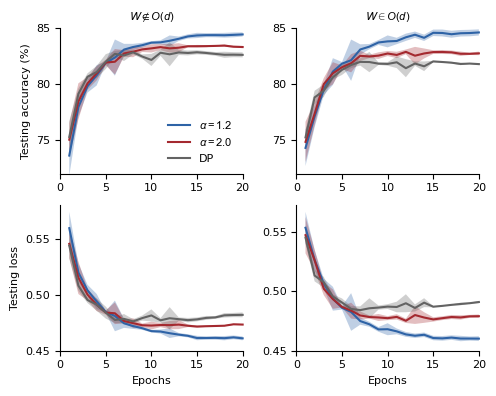

In [33]:
from constants import FIGS_DIR
fig, axs = phase_ensembles(".droot/full_models/6L-hidden=256-max_len=512-rescaled/", is_ops=[False,True], selected_alphas='1.2,2', qk_share=False)
plt.tight_layout()
SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
fig_file = 'phase_ensembles'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()

# Attention weights

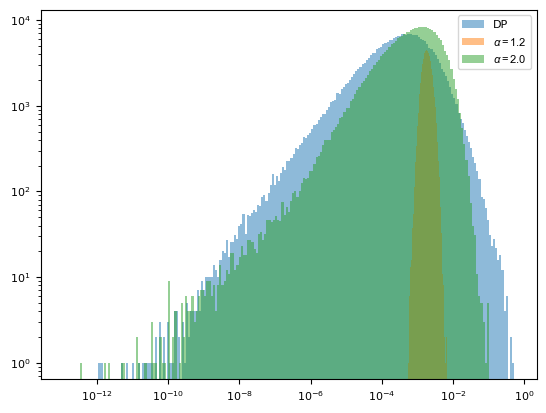

In [ ]:
paths = [".droot/long_sequence/attn_graph_results_dp.npz", ".droot/long_sequence/attn_graph_results_1.2.npz", ".droot/long_sequence/attn_graph_results_2.0.npz"]

labels = ['DP', r'$\alpha = 1.2$', r'$\alpha = 2.0$']

fig, ax = plt.subplots()
for i, path in enumerate(paths):
    data = np.load(path)
    attn_weights = np.squeeze(data["attention_weights"])
    np.fill_diagonal(attn_weights, np.nan)
    bins = np.logspace(np.log10(np.nanmin(attn_weights)), np.log10(np.nanmax(attn_weights)), 200)
    # bins = np.logspace(-3, 0, 100)
    # print(np.nanmin(attn_weights), np.nanmax(attn_weights))
    # bins, counts = np.histogram(attn_weights.flatten(), bins=bins)
    ax.hist(attn_weights.flatten(), bins=bins, label=labels[i], alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

In [306]:
%matplotlib inline
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmasher as cm

# paths = [".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model=0/andrew_results_1.npz",
#          ".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model=0/andrew_results_1.npz",
#         ".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/opdpformer-imdb-qqv/model=0/andrew_results_1.npz"]
paths = [".droot/length_500/attn_graph_results_1.2.npz", ".droot/length_500/attn_graph_results_2.0.npz", ".droot/length_500/attn_graph_results_dp.npz"]
# paths = [".droot/length_32/attn_graph_results_1.2.npz", ".droot/length_32/attn_graph_results_2.0.npz", ".droot/length_32/attn_graph_results_dp.npz"]

seq_len = 500
shortest_path_lengths = []
for i in range(3):
    path = paths[i]
    ax = axs[i]
    attn_weights = np.squeeze(np.load(path)["attention_weights"])[:seq_len, :seq_len]
    edge_weights = 1/np.abs(attn_weights)
    np.fill_diagonal(edge_weights, 0)
    G = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)
    shortest_path_length = np.full(attn_weights.shape, np.inf)
    np.fill_diagonal(shortest_path_length, 0)
    for source in range(shortest_path_length.shape[0]):
        lengths, shortest_paths = nx.single_source_dijkstra(G, source) # Compute shortest paths using Dijkstra's algorithm
        for target in lengths:
            shortest_path_length[source, target] = len(shortest_paths[target]) - 1
    shortest_path_lengths.append(shortest_path_length)
    # shortest_path = data["shortest_path"]

Max shortest path: 3.0
Mean shortest path: 1.15238
Max shortest path: 9.0
Mean shortest path: 2.986452
Max shortest path: 14.0
Mean shortest path: 4.240332


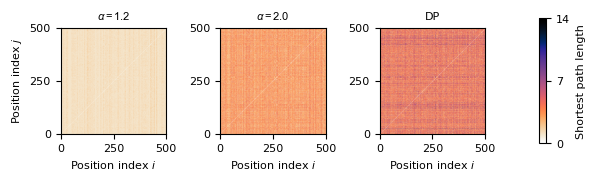

In [385]:
from scipy.cluster.hierarchy import linkage, leaves_list
def agglomerative_reorder(distance_matrix, method="average"):
    """
    Perform agglomerative clustering on a distance matrix and 
    return a reordered matrix suitable for visualization.
    
    Parameters
    ----------
    distance_matrix : ndarray (n x n)
        Symmetric distance matrix.
    method : str
        Linkage method ('single', 'complete', 'average', 'ward', etc.).
        
    Returns
    -------
    reordered_matrix : ndarray (n x n)
        Distance matrix reordered according to clustering.
    order : ndarray (n,)
        The order of indices after clustering.
    """
    # Ensure distance matrix is square
    n, m = distance_matrix.shape
    assert n == m, "Distance matrix must be square"
    
    # Convert to condensed form (upper triangular as 1D vector)
    condensed = distance_matrix[np.triu_indices(n, k=1)]
    
    # Perform hierarchical clustering
    Z = linkage(condensed, method=method)
    
    # Get the order of leaves after clustering
    order = leaves_list(Z)
    
    # Reorder the distance matrix
    reordered_matrix = distance_matrix[np.ix_(order, order)]
    
    return reordered_matrix, order

titles = [r'$\alpha = 1.2$', r'$\alpha = 2.0$', 'DP']
gridspec = {'width_ratios': [1, 1, 1, 0.07]}
fig, axs = plt.subplots(1,4, gridspec_kw=gridspec, figsize=(6,1.9))
for i in range(3):
    ax = axs[i]
    shortest_path_length = shortest_path_lengths[i]
    im = ax.imshow(shortest_path_length, vmin=0, vmax=14, cmap=cm.torch_r, origin='lower')
    print("Max shortest path:", np.nanmax(shortest_path_length))
    # reordered_matrix, order = agglomerative_reorder(shortest_path_length, method="complete")
    # im = ax.imshow(reordered_matrix, vmin=0, vmax=14, cmap=cm.torch_r)
    print("Mean shortest path:", shortest_path_length.mean())
    ax.set_aspect(1)
    ax.set_title(titles[i])
    ax.set_xlabel(r'Position index $i$')
    ax.set_xticks([0,250,500])
    ax.set_yticks([0,250,500])
    if i == 0:
        ax.set_ylabel(r'Position index $j$')
        
cbar = fig.colorbar(im, cax=axs[3], fraction=0.000002)
cbar.ax.set_ylabel("Shortest path length")
cbar.ax.set_yticks([0, 7, 14])

plt.tight_layout()
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
fig_file = 'shortest_path_matrix'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight', dpi=500)
plt.show()

# torch_r 
# rainforest_r
# freeze_r
# arctic_r
# amethyst_r

# Diffusion map

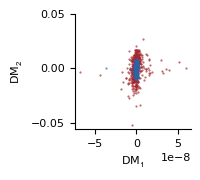

21 of the furthest embeddings in the sequence.


In [ ]:
# paths = [".droot/length_500/attn_graph_results_1.2.npz", ".droot/length_500/attn_graph_results_2.0.npz"]
# # paths = [".droot/length_32/attn_graph_results_1.2.npz", ".droot/length_32/attn_graph_results_2.0.npz"]

# fig, ax = plt.subplots(figsize=(1.5,1.5))
# colors = ["#2E63A6", "#A4292F"]
# i1, i2 = -1, -2
# for i in range(2):
#     diff_map_results = np.load(paths[i])["diffusion_map"]
#     far_xy_idxs = np.load(paths[i])["far_xy_idxs"]
#     # centre = np.mean(diff_map_results[far_xy_idxs], axis=0)
#     # centred_results = diff_map_results[far_xy_idxs] - centre
#     centred_results = diff_map_results - np.mean(diff_map_results, axis=0)
#     ax.scatter(centred_results[:,i1], centred_results[:,i2], marker='.', c=colors[i], alpha=0.8, s=1, zorder=-i)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xticks([-5e-8, 0, 5e-8])
# ax.set_yticks([-0.05, 0, 0.05])
# ax.set_xlabel(r'DM$_1$')
# ax.set_ylabel(r'DM$_2$')
# from constants import FIGS_DIR
# SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
# fig_file = 'diffusion_map'
# fig_file += '.pdf'
# plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
# plt.show()
# print(f"{len(far_xy_idxs)} of the furthest embeddings in the sequence.")

paths = [".droot/L-d-grid-v2/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model=0/attn_graph_results.npz", 
         ".droot/L-d-grid-v2/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model=0/attn_graph_results.npz"]

# paths = paths[:1]

fig, ax = plt.subplots(figsize=(1.5,1.5))
colors = ["#2E63A6", "#A4292F"]
# i1, i2 = -1, -2
i1, i2 = -2, -3

for i in range(len(paths)):
    eigvals = np.load(paths[i])["eigvals"]
    eigvecs = np.load(paths[i])["diffusion_map"]
    bdwth = np.load(paths[i])["bdwth"].item()  # for checking bandwidth used

    # order based on eigvals from large to small
    ii = np.argsort(eigvals)
    eigvals = eigvals[ii]
    eigvecs = eigvecs[:,ii] 

    diff_map_results = eigvals**bdwth * eigvecs

    far_xy_idxs = np.load(paths[i])["far_xy_idxs"]
    # centre = np.mean(diff_map_results[far_xy_idxs], axis=0)
    # centred_results = diff_map_results[far_xy_idxs] - centre
    # centred_results = diff_map_results - np.mean(diff_map_results, axis=0)
    centred_results = diff_map_results
    ax.scatter(centred_results[:,i1], centred_results[:,i2], marker='.', c=colors[i], alpha=0.8, s=1, zorder=-i)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xticks([-5e-8, 0, 5e-8])
# ax.set_yticks([-0.05, 0, 0.05])
ax.set_xlabel(r'DM$_1$')
ax.set_ylabel(r'DM$_2$')
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'pretrained-analysis')    
if not isdir(SAVE_DIR): makedirs(SAVE_DIR) 
fig_file = 'diffusion_map'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()
print(f"{len(far_xy_idxs)} of the furthest embeddings in the sequence.")

# Particular shortest path results

In [ ]:
paths = [".droot/length_500/attn_graph_results_1.2.npz", ".droot/length_500/attn_graph_results_2.0.npz", ".droot/length_500/attn_graph_results_dp.npz"]

# Read from txt file
path = ".droot/length_500/text_1.2.txt"
# Choose two tokens in the sequence 
with open(path, "r") as f:
    tokens = f.read().splitlines()
# Studying these a little, we interestingly find the adjacent words "much" (pos 127) and "danger" (pos 128) actually require 13 steps to connect in DPformer
# Let's see how many steps it takes to connect them for fracformers...
seq_len = 500
token_idxs_to_plot = []
for i in range(3):
    path = paths[i]
    ax = axs[i]
    attn_weights = np.squeeze(np.load(path)["attention_weights"])[:seq_len, :seq_len]
    edge_weights = 1/np.abs(attn_weights)
    np.fill_diagonal(edge_weights, 0)
    G = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)
    shortest_path_length = np.full(attn_weights.shape, np.inf)
    np.fill_diagonal(shortest_path_length, 0)
    lengths, shortest_paths = nx.single_source_dijkstra(G, 127) # Compute shortest paths using Dijkstra's algorithm
    print(f"Shortest path between {tokens[127]} and {tokens[128]}: {len(shortest_paths[128]) - 1}")
    token_idxs_to_plot.append(shortest_paths[128])
tokens_to_plot = [[tokens[i] for i in shortest_path] for shortest_path in token_idxs_to_plot]
print(tokens_to_plot)

Shortest path between ▁much and ▁danger: 1
Shortest path between ▁much and ▁danger: 2
Shortest path between ▁much and ▁danger: 13
[['▁much', '▁danger'], ['▁much', 'ent', '▁danger'], ['▁much', '▁might', 'br', 'br', 'br', '"', '▁comes', "'", "'", "'", '▁some', '▁with', 'I', '▁danger']]


In [ ]:
# Find corresponding attention weights for plotting
edge_weights_to_plot = []
for i in range(3):
    path = paths[i]
    attn_weights = np.squeeze(np.load(path)["attention_weights"])[:seq_len, :seq_len]
    token_idxs = token_idxs_to_plot[i]
    edge_weights = []
    for i, j in zip(token_idxs[:-1], token_idxs[1:]):
        edge_weights.append( attn_weights[i, j] )
    edge_weights_to_plot.append(edge_weights)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


['ent', '▁much', '▁might', 'br', 'br', 'br', '"', '▁comes', "'", "'", "'", '▁some', '▁with', 'I', '▁danger']


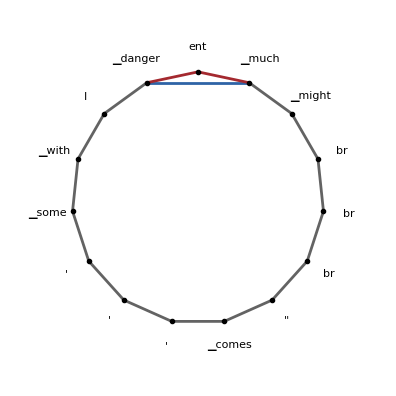

In [ ]:
from matplotlib.collections import LineCollection
# Rescale edge weights for visibility
factor = 1 / np.max([np.max(ew) for ew in edge_weights_to_plot])
ewtp_rescaled = [[ew * factor for ew in edge_weights] for edge_weights in edge_weights_to_plot]
# Plot 
words = [tokens_to_plot[1][1]] + tokens_to_plot[2]
print(words)
fig, ax = plt.subplots(figsize=(4,4))
# Draw words
theta = np.linspace(0, 360, 15, endpoint=False)
x = np.cos(np.radians(theta) + np.pi/2)
y = np.sin(np.radians(theta) + np.pi/2)
text_radius = 1.2
ax.plot(x, y, 'k.')
for i in range(len(words)):
    word = words[i]
    ax.annotate(word, (-x[i]*text_radius, y[i]*text_radius), size=8, ha='center', va='center')
# Draw 1.2 attention
# ax.plot([x[1], x[-1]], [y[1], y[-1]], c="#2E63A6", lw=2, zorder=-3)
ax.plot([x[1], x[-1]], [y[1], y[-1]], c="#2E63A6", lw=ewtp_rescaled[0][0], zorder=-3)
# Draw 2.0 attention
# ax.plot([x[1], x[0], x[-1]], [y[1], y[0], y[-1]], c="#A4292F", lw=2, zorder=-3)
ax.plot([x[1], x[0], x[-1]], [y[1], y[0], y[-1]], c="#A4292F", lw=2, zorder=-3)
# Draw DP attention
# ax.plot(x[1:], y[1:], c="#636363", lw=2, zorder=-3)
plt.axis("equal")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.axis("off")
plt.tight_layout()
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


['ent', '▁much', '▁might', 'br', 'br', 'br', '"', '▁comes', "'", "'", "'", '▁some', '▁with', 'I', '▁danger']


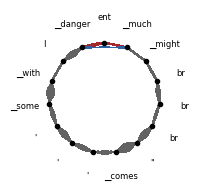

In [371]:
from matplotlib.collections import LineCollection

def taper_linecollection(lc, end_width, mid_widths, n_subsegments=100):
    """
    Modify a LineCollection so each line tapers:
    - linewidth = 2 at the ends (nodes)
    - linewidth = mid_widths[i] at the middle
    
    Parameters
    ----------
    lc : LineCollection
        The existing line collection (with N segments).
    mid_widths : list or array-like of length N
        Target linewidth at the midpoint of each line.
    n_subsegments : int
        How many subsegments to split each line into (for smooth taper).
    
    Returns
    -------
    new_lc : LineCollection
        A new LineCollection with tapered linewidths applied.
    """
    segments = lc.get_segments()
    new_segments = []
    new_linewidths = []
    
    for seg, mid_w in zip(segments, mid_widths):
        (x0, y0), (x1, y1) = seg
        # Interpolated points along the edge
        t = np.linspace(0, 1, n_subsegments+1)
        xs = np.linspace(x0, x1, n_subsegments+1)
        ys = np.linspace(y0, y1, n_subsegments+1)
        
        # Build subsegments
        pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
        segs = np.concatenate([pts[:-1], pts[1:]], axis=1)

        # Linewidth profile: end_width at ends, mid_w at center
        lw_profile = end_width + (mid_w - end_width) * np.sin(np.pi * t[:-1])**2

        new_segments.extend(segs)
        new_linewidths.extend(lw_profile)
    
    new_lc = LineCollection(new_segments, linewidths=new_linewidths, colors=lc.get_colors(), antialiased=False, zorder=lc.get_zorder())
    return new_lc

def create_lc(X, Y, zorder=1):
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return LineCollection(segments, linewidths=2, zorder=zorder)
# Rescale edge weights for visibility
# ewtp_rescaled = [[1/ew for ew in edge_weights] for edge_weights in edge_weights_to_plot]
# factor = 1 / np.max([np.max(ew) for ew in ewtp_rescaled])
# ewtp_rescaled = [[ew * factor for ew in edge_weights] for edge_weights in ewtp_rescaled]
factor = 1 / np.min([np.min(ew) for ew in edge_weights_to_plot])
ewtp_rescaled = [[ew * factor * 0.25 for ew in edge_weights] for edge_weights in edge_weights_to_plot]
# Plot 
words = [tokens_to_plot[1][1]] + tokens_to_plot[2]
print(words)
fig, ax = plt.subplots(figsize=(2,2))
# Draw words
theta = np.linspace(0, 360, 15, endpoint=False)
x = np.cos(np.radians(theta) + np.pi/2)
y = np.sin(np.radians(theta) + np.pi/2)
text_radius = 1.45
ax.plot(x, y, 'k.', zorder=5)
for i in range(len(words)):
    word = words[i]
    ax.annotate(word, (-x[i]*text_radius, y[i]*text_radius), size=6, ha='center', va='center')
# Draw 1.2 attention
X = np.array([x[1], x[-1]])
Y = np.array([y[1], y[-1]])
lc = create_lc(X,Y, zorder=3)
lc.set_color("#2E63A6")
# lc.set_alpha(ewtp_rescaled[0])
# lc.set_linewidths(ewtp_rescaled[0])
lc = taper_linecollection(lc, 1, ewtp_rescaled[0], n_subsegments=500)
ax.add_collection(lc)
# ax.plot([x[1], x[-1]], [y[1], y[-1]], c="#2E63A6", lw=2, zorder=-3)
# Draw 2.0 attention
# ax.plot([x[1], x[0], x[-1]], [y[1], y[0], y[-1]], c="#A4292F", lw=2, zorder=-3)
X = np.array([x[1], x[0], x[-1]])
Y = np.array([y[1], y[0], y[-1]])
lc = create_lc(X,Y)
lc.set_color("#A4292F")
# lc.set_alpha(ewtp_rescaled[1])
# lc.set_linewidths(ewtp_rescaled[1])
lc = taper_linecollection(lc, 1, ewtp_rescaled[1], n_subsegments=500)
ax.add_collection(lc)
# Draw DP attention
# ax.plot(x[1:], y[1:], c="#636363", lw=2, zorder=-3)
X = np.array(x[1:])
Y = np.array(y[1:])
lc = create_lc(X,Y)
lc.set_color("#636363")
# lc.set_alpha(ewtp_rescaled[2])
# lc.set_linewidths(ewtp_rescaled[2])
lc = taper_linecollection(lc, 1, ewtp_rescaled[2], n_subsegments=500)
ax.add_collection(lc)
plt.axis("equal")
plt.xlim([-1.6, 1.6])
plt.ylim([-1.6, 1.6])
plt.axis("off")
plt.tight_layout()
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
fig_file = 'shortest_path_example'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()

# Mean spectral gaps

In [432]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmasher as cm

paths = [".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model=0/andrew_results_2.npz",
         ".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model=0/andrew_results_2.npz",
        ".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/opdpformer-imdb-qqv/model=0/andrew_results_2.npz"]

for i in range(3):
    path = paths[i]
    mean_spectral_gaps = np.load(paths[i])["mean_spectral_gaps"]

# Spectral gap

In [308]:
def get_all_test_results():
    is_rescale_dist=True
    fns_manifold='rd'
    models_root = ".droot/L-d-grid-v2/"
    qk_shares = [False]
    selected_alphas='1.0,1.2,1.4,1.6,1.8,2'
    metric='val_acc'
    selected_dataset='imdb'
    is_op=True

    fns_type = fns_manifold + 'fns' + MODEL_SUFFIX 
    other_model_type = 'dpformer'
    if is_op:
        fns_type = 'op' + fns_type
        other_model_type = 'op' + other_model_type
    model_types_to_plot = [fns_type, other_model_type]

    is_op, is_rescale_dist = str2bool(is_op), str2bool(is_rescale_dist)
    qk_shares = str2ls(qk_shares)        
    selected_alphas = [float(selected_alpha) for selected_alpha in str2ls(selected_alphas)]
    eps = 1

    # Regular expression pattern
    pattern = r"\d+L-hidden=\d+-max_len=512"
    if is_rescale_dist:            
        pattern += "-rescaled"

    # Extract matching subfolders
    layer_dirs_dict = {}
    layers, emb_ds = [], []
    for layer_dir in os.listdir(models_root):
        is_match = re.fullmatch(pattern, layer_dir)
        if is_match:
            #layer, emb_d = int(is_match.group(1)), int(is_match.group(2))
            layer = int(layer_dir.split('L')[0])          
            #emb_d = int(layer_dir.split('-')[1].split('=')[1])
            emb_d = int(layer_dir.split('-')[1].split('=')[1])  
            if isdir(njoin(models_root, layer_dir)):
                layer_dirs_dict[f'{layer}-{emb_d}'] = njoin(models_root, layer_dir)
            layers.append(layer)
            emb_ds.append(emb_d)
    layers = np.array(sorted(list(set(layers)))); layers = layers[layers < 4]
    emb_ds = np.array(sorted(list(set(emb_ds)))); emb_ds = emb_ds[emb_ds < 65]
    
    #nrows, ncols = len(qk_shares), len(selected_alphas)
    nrows, ncols = len(qk_shares), len(layers)

    # (model_types, qk_share, L, d_model)
    N_model_types = len(selected_alphas) + 1
    metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds), 5])
    # average_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    # std_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
    # average_metric_matrix[:] = np.nan
    # std_metric_matrix[:] = np.nan
    model_types_plotted = []
    for (qk_ii,qk_share),(layer_idx,layer),(emb_d_idx,emb_d) in\
         product(enumerate(qk_shares),enumerate(layers),enumerate(emb_ds)):

        qk_share_dirname = 'config_qqv' if qk_share else 'config_qkv'
        print(f'qk_share = {qk_share}, layer = {layer}, emb_d = {emb_d}')    
        # directories matching the above setting in the triple for loop
        if f'{layer}-{emb_d}' in layer_dirs_dict.keys():
            if qk_share_dirname in os.listdir(layer_dirs_dict[f'{layer}-{emb_d}']):
                setting_dir = njoin(layer_dirs_dict[f'{layer}-{emb_d}'], qk_share_dirname)
            else:
                continue
        else:
            continue
        # for _ in range(2):
        #     setting_dir = njoin(setting_dir, os.listdir(setting_dir)[0])
        setting_dir = njoin(setting_dir, 'imdb')
        setting_dir = njoin(setting_dir, os.listdir(setting_dir)[0])
        DCT_ALL = collect_model_dirs(setting_dir, suffix=MODEL_SUFFIX)
        model_df = DCT_ALL[fns_type].dropna(subset='alpha')
        model_df.reset_index(drop=True, inplace=True)

        for model_type in model_types_to_plot:
            if model_type in DCT_ALL.keys():
                df_model = DCT_ALL[model_type]
            else:
                continue
            matching_df = df_model[(df_model['ensembles']>0)&(df_model['qk_share']==qk_share)&
                                   (df_model['is_op']==is_op)&                                    
                                   (df_model['model_dir'].str.contains(selected_dataset))&
                                   (df_model['model_dir'].str.contains(f'/{model_type}-'))]

            if model_type not in model_types_plotted:
                model_types_plotted.append(model_type)
            lstyle_model = LINESTYLE_DICT[model_type]            
            for alpha_idx, alpha in enumerate(selected_alphas):  
                # if is fns type
                is_fns = 'fns' in model_type
                alpha = alpha if is_fns else None
                # -------------------- SINK, DP -------------------- 
                model_info = matching_df 
                # -------------------- FNS --------------------
                if is_fns:
                    condition = (matching_df['alpha']==alpha) & (matching_df['bandwidth']==eps)
                    model_info = model_info[condition]
                else:
                    alpha_idx = len(selected_alphas)
                if model_info.shape[0] > 0:
                    seeds, qk_share = (model_info[k].item() for k in ('seeds', 'qk_share'))                
                    epochs, run_perf_all = load_seed_runs(model_info['model_dir'].item(), seeds, metric)   
                else:
                    continue

                if run_perf_all is not None:
                    metric_curves = get_metric_curves(run_perf_all)  

                if run_perf_all is not None:
                    metric_matrix[qk_ii, alpha_idx, layer_idx, emb_d_idx, :] = run_perf_all.loc[run_perf_all.index[-1]:, metric]
                    # average_metric_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                    #     np.nanmean(run_perf_all.loc[run_perf_all.index[-1]:,metric])
                    #     #np.nanmedian(run_perf_all.loc[run_perf_all.index[-1]:,metric])                                                
                    # std_metric_matrix[qk_ii,alpha_idx,layer_idx,emb_d_idx] =\
                    #     np.nanstd(run_perf_all.loc[run_perf_all.index[-1]:,metric])
                if not is_fns:
                    break  # only do once if model is NOT FNS type   
    return metric_matrix

In [309]:
metric_matrix = get_all_test_results()   

qk_share = False, layer = 1, emb_d = 8
qk_share = False, layer = 1, emb_d = 16
qk_share = False, layer = 1, emb_d = 32
qk_share = False, layer = 1, emb_d = 64


/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The beha

qk_share = False, layer = 1, emb_d = 8
qk_share = False, layer = 1, emb_d = 16
qk_share = False, layer = 1, emb_d = 32
qk_share = False, layer = 1, emb_d = 64


/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
/Users/andrewly/Desktop/Fracformer/code/fractional-attn-main/nlp-tutorial/UTILS/mutils.py:223: FutureWarning: The beha

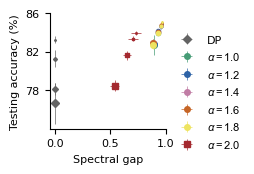

In [ ]:
from matplotlib.colors import to_rgb

data = np.load(".droot/all_spectral_gap.npz")
spectral_gap = data["spectral_gap"]
X_lens = data["X_lens"]
alphas = data["alphas"]
dimensions = data["dimensions"]

metric_matrix = get_all_test_results()   
colors = ["#636363", "#469C76", "#2E63A6", "#C17DA5", "#C66526", "#EEE461", "#A4292F"]
# marker_alphas = [1, 0.8, 0.6, 0.4]
marker_alphas = [1] * 4
marker_sizes = [8,6,4,2]
fig, ax = plt.subplots(figsize=(1.5,1.5))
for model_idx in range(7):
    if model_idx == 0: # DPformer
        idx = -1
    else:
        idx = model_idx - 1
    test_accs = np.mean(metric_matrix[0,idx,0,:,:], axis=-1)
    gap = np.mean(spectral_gap[model_idx, :, :], axis=-1)
    color = colors[model_idx]
    r, g, b = to_rgb(color)
    color = np.array([(r, g, b, alpha) for alpha in marker_alphas])
    xerr = np.std(spectral_gap[model_idx, :, :], axis=-1)
    yerr = np.std(metric_matrix[0,idx,0,:,:], axis=-1)
    # ax.scatter(gap, test_accs, clip_on=False, label='DP' if model_idx==0 else rf'$\alpha={alphas[idx]:.1f}$', color=color, s=marker_sizes)
    if model_idx == 0:
        marker_style = 'D'
        size_factor = 0.5
    elif model_idx == 6:
        marker_style = 's'
        size_factor = 0.5
    else:
        marker_style = '.'
        size_factor = 1
    for plot_idx, (s, g, ta, xe, ye) in enumerate(zip(marker_sizes, gap, test_accs, xerr, yerr)):
        if plot_idx == 0:
            ax.errorbar(g, ta, xerr=xe, yerr=ye, fmt=marker_style, c=color[0], markersize=s*size_factor, label='DP' if model_idx==0 else rf'$\alpha={alphas[idx]:.1f}$', elinewidth=1)
        else:
            ax.errorbar(g, ta, xerr=xe, yerr=ye, fmt=marker_style, c=color[0], markersize=s*size_factor, elinewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(top=86)
ax.set_yticks([78, 82, 86])
ax.set_xlim(right=1)
ax.set_xlabel('Spectral gap')
ax.set_ylabel('Testing accuracy (%)')
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9))
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
plt.savefig(njoin(SAVE_DIR, "spectral_gap_vs_acc.pdf"), bbox_inches='tight')
plt.show()